# 1. Dataset for emotion prediction

In [36]:
from sklearn.ensemble import AdaBoostClassifier
from matplotlib import pyplot as plt
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
import nltk
import numpy as np
import pandas as pd
import pickle
from nltk.corpus import stopwords
from datasets import load_dataset
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\usicc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

'0': sadness
               '1': joy
               '2': love
               '3': anger
               '4': fear
               '5': surprise

In [ ]:
%pip install datasets nltk

In [ ]:
dataset = load_dataset('json', data_files={'train': 'train.jsonl','test':'validation.jsonl'})

vectorizer = CountVectorizer(max_features=500, min_df=4, max_df=0.7, stop_words=stopwords.words('english'))
X_train_vec = vectorizer.fit_transform(dataset['train']['text'])

vocabulary = vectorizer.get_feature_names_out()

tfidf = TfidfTransformer()

X_train_idf = tfidf.fit_transform(X_train_vec)

X_test_vec = vectorizer.transform(dataset['test']['text'])

X_test_idf = tfidf.transform(X_test_vec)

X_train = X_train_idf.toarray()
X_test = X_test_idf.toarray()

X_train, X_test, y_train, y_test = X_train,X_test,dataset['train']['label'],\
                            dataset['test']['label']

# 3. Blending

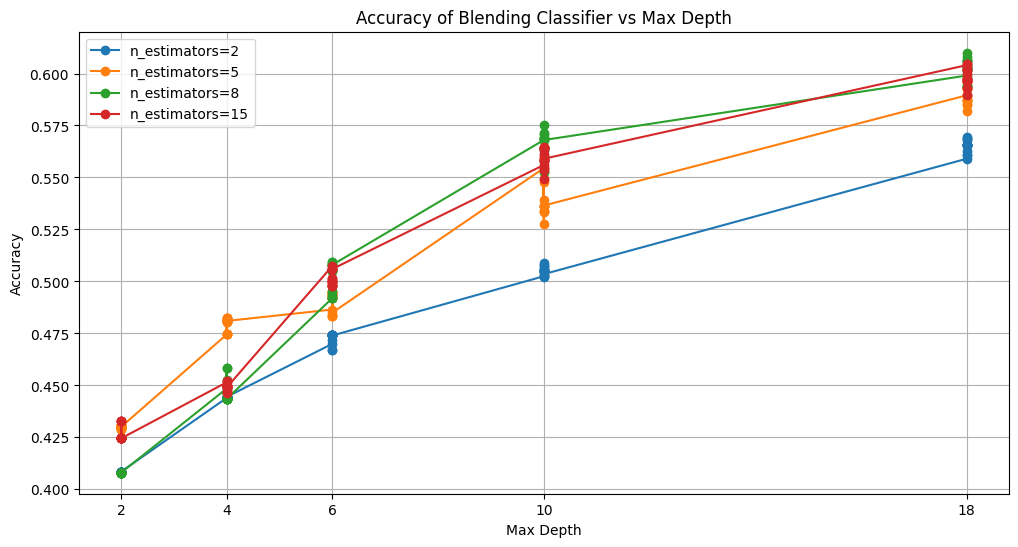

In [ ]:
X_train_0, X_train_1, y_train_0, y_train_1 = train_test_split(X_train, y_train, test_size=0.33, random_state=42)

def make_blending_prediction(basic_clfs, final_clf, data):
    y0 = []
    for c in basic_clfs:
        y0.append(c.predict(data))
    y0_t = np.array(y0).transpose()
    return final_clf.predict(y0_t)

n_estimators_list = [2, 5, 8, 15]
max_depth_list = [2, 4, 6, 10, 18]
min_samples_split_list = [2, 5, 10, 15] 
min_samples_leaf_list = [1, 2, 4, 6] 

results = []

for max_depth in max_depth_list:
    for n_estimators in n_estimators_list:
        for min_samples_split in min_samples_split_list:
            for min_samples_leaf in min_samples_leaf_list:
                crf = []
                y_pred_1 = []
                for n in range(1, 11):
                    clf = RandomForestClassifier(
                        n_estimators=n_estimators,
                        max_depth=max_depth,
                        min_samples_split=min_samples_split,
                        min_samples_leaf=min_samples_leaf,
                        random_state=n
                    )
                    clf.fit(X_train_0, y_train_0)
                    crf.append(clf)
                    y_pred_1.append(clf.predict(X_train_1).reshape(-1, 1))

                y_pred_1t = np.hstack(y_pred_1)

                clf_final = RandomForestClassifier(n_estimators=10, max_depth=6, random_state=42)
                clf_final.fit(y_pred_1t, y_train_1)

                y_test_pred = make_blending_prediction(crf, clf_final, X_test)
                acc = accuracy_score(y_test, y_test_pred)

                results.append((n_estimators, max_depth, min_samples_split, min_samples_leaf, acc))

results_df = pd.DataFrame(results, columns=['n_estimators', 'max_depth', 'min_samples_split', 'min_samples_leaf', 'accuracy'])

plt.figure(figsize=(12, 6))
for n_estimators in n_estimators_list:
    subset = results_df[results_df['n_estimators'] == n_estimators]
    plt.plot(subset['max_depth'], subset['accuracy'], marker='o', linestyle='-', label=f'n_estimators={n_estimators}')

plt.title('Accuracy of Blending Classifier vs Max Depth')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.xticks(max_depth_list)
plt.legend()
plt.grid()
plt.show()

# 4. Stacking

c:\Users\usicc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\usicc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\usicc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\usicc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\usicc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the 

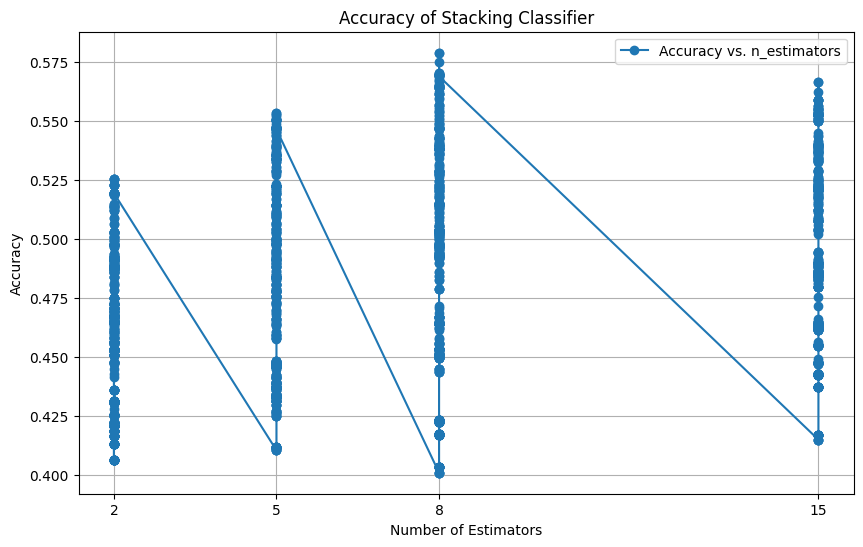

In [ ]:
X_train_0, X_train_1, y_train_0, y_train_1 = train_test_split(X_train, y_train, test_size=0.33, random_state=42)

def make_stacking_prediction(basic_clfs, final_clf, data):
    y0 = []
    for c in basic_clfs:
        y0.append(c.predict(data))
    y0_t = np.array(y0).transpose() 
    return final_clf.predict(y0_t)

n_estimators_list = [2, 5, 8, 15]
max_depth_list = [2, 4, 6, 10, 18]
min_samples_split_list = [2, 5, 10, 15] 
min_samples_leaf_list = [1, 2, 4, 6] 

C_list = [0.1, 1, 10]
solver_list = ['liblinear', 'saga']

results = []

for n_estimators in n_estimators_list:
    for max_depth in max_depth_list:
        for min_samples_split in min_samples_split_list:
            for min_samples_leaf in min_samples_leaf_list:
                crf = []
                y_pred_1 = []
                for n in range(1, 11):
                    clf = RandomForestClassifier(
                        n_estimators=n_estimators,
                        max_depth=max_depth,
                        min_samples_split=min_samples_split,
                        min_samples_leaf=min_samples_leaf,
                        random_state=n
                    )
                    clf.fit(X_train_0, y_train_0)
                    crf.append(clf)
                    y_pred_1.append(clf.predict(X_train_1).reshape(-1, 1))

                y_pred_1t = np.hstack(y_pred_1)

                for C in C_list:
                    for solver in solver_list:
                        clf_final = LogisticRegression(C=C, solver=solver, random_state=42, max_iter=1000)
                        clf_final.fit(y_pred_1t, y_train_1)

                        y_test_pred = np.column_stack([clf.predict(X_test) for clf in crf])
                        final_predictions = clf_final.predict(y_test_pred)

                        acc = accuracy_score(y_test, final_predictions)

                        results.append((n_estimators, max_depth, min_samples_split, min_samples_leaf, acc))

results_df = pd.DataFrame(results, columns=['n_estimators', 'max_depth', 'min_samples_split', 'min_samples_leaf', 'accuracy'])

plt.figure(figsize=(10, 6))
plt.plot(results_df['n_estimators'], results_df['accuracy'], marker='o', label='Accuracy vs. n_estimators')
plt.title('Accuracy of Stacking Classifier')
plt.xlabel('Number of Estimators')
plt.ylabel('Accuracy')
plt.xticks(results_df['n_estimators'].unique())
plt.legend()
plt.grid()
plt.show()